## Background
Social Media has evolved into a major platform for political advertisement over the last decades, overtaking many of the former forms of visual advertising (television, offline) (Fowler 2021). This further intensifies the impact that social media has on our current political and social landscape. The desirability of these implications is highly debatable, some argue for significant deliberation (Castells 2012) while others point more toward the significant dangers that this development entails (Persily & Tucker 2020).

Notwithstanding these differences, it becomes clear that a further understanding of especially politically motivated activity on social is of utmost importance for developing a clearer picture of our political landscape. 

While this field has in the past mainly concentrated on textual data, a rapid development in image and video analysis using quantitative methods of computer vision has opened a huge potential to also include visual data in the analysis. A recent example of this is the work by Fowler et al. (2020), where the authors make use of the Facebook Aid Library as well as television data to capture the strategic use of visual content in political campaigning. They show specific attributes of certain candidates through within-candidate comparison as well as the specifics of social media through an inter-platform comparison.

## Prerequisites

In [3]:
# Install general packages 
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
from collections import Counter
import pandas as pd
import seaborn as sns 

# Install and load packages for web-scraping 
import requests
from bs4 import BeautifulSoup
from io import BytesIO

# Install packages for Computer Vision 
import cv2
from PIL import Image
import torch 




## Data

The URLs are retrieved from the Facebook ad library (https://www.facebook.com/ads/library/?active_status=all&ad_type=political_and_issue_ads&country=SE&media_type=all). The two organizations were selected based on their leading role in terms of Facebook ad expenditure among environmental organization in Germany. In the second step, the 10 most recent advertising images from Greenpeace and NABU are retrieved as a database for the following analysis.

For some reason the URLs seem to change at some point so the following lines might not work anymore, I still included them as well for the sake of completeness.
For better replicability, I also included the code to directly load the picture from a GitHub - repository.

In [ ]:
# Clone Github in Google Colab files to access images and urls
!git clone https://github.com/linuscov/CV.git

In [4]:
# Loading URLs
urls = pd.read_csv("/content/CV/urls.csv", delimiter = ",")

# Create a list of URLs 
urls_ls = list()
for url in urls:
  urls_ls.append(url)

In [ ]:
# Loading images 
images = []
images_array = []
for url in urls_ls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img_array = np.asarray(img)
  images_array.append(img_array)
  images.append(img)

In [ ]:
# Save Images 
for img in images:
  file_name =  str('%02d' % images.index(img)) + "_img.jpeg"
  img.save(file_name)

For directly importing the **images from Github**, start from here.

In [4]:
# Loading images from storage
x2 =[]
x = range(20)
for i in x:
  two_digit = '%02d' % i
  x2.append(two_digit)

images = []
images_array = []
for i in x2:
  path = "/content/CV/Pictures/" + str(i) + "_img.jpeg"
  img = Image.open(path)
  img_array = np.asarray(img)
  images_array.append(img_array)
  images.append(img)


## Comparison of Pictures (Descriptive)

### Compare Color Composition


In [25]:
#Check for shapes of pictures   
shapes = []
for img in images_array:
  shape = img.shape
  shapes.append(shape)

In [5]:
# Resizing all image to the the same seize so that all pictures have the same weight for the following 
# analysis of color composiiton 
images_resized = []
images_resized_array = []
for i in images:
    img = i.resize((300,300))
    img_array = np.asarray(img)
    images_resized.append(img)
    images_resized_array.append(img_array)

In [6]:
#Define images from Greenpeace and NABU 
images_nabu = images[0:10]
images_gp= images[10:20]

images_nabu_array = images_array[0:10]
images_gp_array = images_array[10:20]

images_nabu_resized = images_resized[0:10]
images_gp_resized = images_resized[10:20]

images_nabu_resized_array = images_resized_array[0:10]
images_gp_resized_array = images_resized_array[10:20]

In [7]:
# Merge Pictures from both organisation together in order to conduct the analysis of color 
# composition for all pictures from one organization 

# Merge Greenpeace images together 
widths, heights = zip(*(i.size for i in images_gp_resized))

# Define width and height of the merged picture
total_width = sum(widths)
max_height = max(heights)

green = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images_gp_resized:
  green.paste(im, (x_offset,0))
  x_offset += im.size[0]


# Merge NABU images together 
widths, heights = zip(*(i.size for i in images_nabu_resized))

# Define width and height of the merged picture
total_width = sum(widths)
max_height = max(heights)

nabu = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images_nabu_resized:
  nabu.paste(im, (x_offset,0))
  x_offset += im.size[0]

In [8]:
# Utility function, rgb to hex
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex
print(rgb2hex([255, 0, 0]))

#ff0000


In [9]:
# Define function to extract color composition 
def plot_image_info(img, k=6):
    # convert image to c2 format
    img_cv = np.array(img) 
    img_rgb = img_cv
    
    #cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

    # resize image to speed up processing time
    resized_img_rgb = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_AREA)

    # reshape the image to be a list of pixels
    img_list = resized_img_rgb.reshape((resized_img_rgb.shape[0] * resized_img_rgb.shape[1], 3))

    # cluster the pixels and assign labels
    clt = KMeans(n_clusters=k)
    labels = clt.fit_predict(img_list)
        
    # count labels to find most popular
    label_counts = Counter(labels)
    total_count = sum(label_counts.values())

    # subset out most popular centroid
    center_colors = list(clt.cluster_centers_)
    ordered_colors = [center_colors[i]/255 for i in label_counts.keys()]
    color_labels = [rgb2hex(ordered_colors[i]*255) for i in label_counts.keys()]
    
    #print(label_counts.values())
    #print(color_labels)
    
    # plots
    plt.figure(figsize=(14, 8))
    plt.subplot(221)
    plt.imshow(img_rgb)
    plt.axis('off')
    
    plt.subplot(222)
    plt.pie(label_counts.values(), labels=color_labels, colors=ordered_colors, startangle=90)
    plt.axis('equal')
    plt.show()

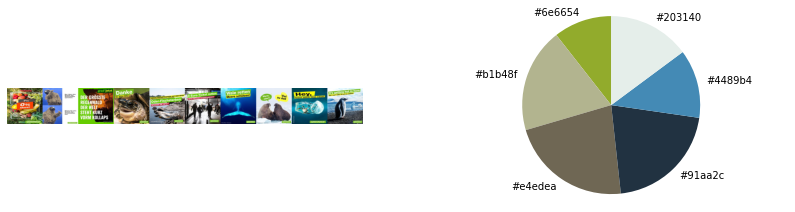

In [10]:
plot_image_info(green)

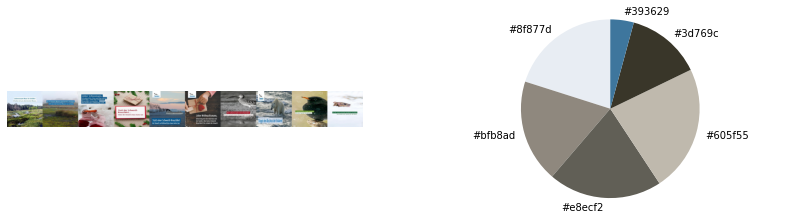

In [11]:
plot_image_info(nabu)

Due to the very limited sample of pictures such a color composition analysis should be treated with caution and mainly be used as a descriptive measure. Here we can see what already becomes apparent from the consideration of the pictures themselves, that Greenpeace seems to an average use more green and lighter colors while Nabu relied more on darker tones of brown, grey, and blue. 

### Similarity measure
In the following, the intra- and inter-similarity of the images posted by the two organizations should be elaborated on in more detail.

In [12]:
# Create an empty matrix to illustrate similarity measures 
matrix = np.empty((10, 10))

In [13]:
# Calculating Structural Similarities between all pictures 
ssims_gp = []
for img_gp in images_gp_resized_array:
  current_img_gp_ssims = []
  for img in images_gp_resized_array:
    struc_sim = ssim(img_gp, img, multichannel=True)
    current_img_gp_ssims.append(struc_sim)
  ssims_gp.append(current_img_gp_ssims)

ssims_nabu = []
for img_nabu in images_nabu_resized_array:
  current_img_nabu_ssims = []
  for img in images_nabu_resized_array:
    struc_sim = ssim(img_nabu, img, multichannel=True)
    current_img_nabu_ssims.append(struc_sim)
  ssims_nabu.append(current_img_nabu_ssims)

ssims_between = []
for img_gp in images_gp_resized_array:
  current_img_gp_ssims = []
  for img in images_nabu_resized_array:
    struc_sim = ssim(img_gp, img, multichannel=True)
    current_img_gp_ssims.append(struc_sim)
  ssims_between.append(current_img_gp_ssims)


In [14]:
# Plotting structural differences 
ssims_gp_df = pd.DataFrame(ssims_gp)

ssims_gp_df[ssims_gp_df > 0.9] = np.nan

cm = sns.light_palette("green", as_cmap=True)

ssims_gp_df.style.background_gradient(cmap=cm, axis = None, low = 0, high = 0.5)

,0,1,2,3,4,5,6,7,8,9
0,nan,0.058025,0.026826,0.050995,0.033173,0.034492,0.056757,0.056637,0.053538,0.046334
1,0.058025,nan,0.073858,0.123081,0.168534,0.081032,0.156226,0.294544,0.172393,0.126077
2,0.026826,0.073858,nan,0.063044,0.069637,0.028467,0.067948,0.095608,0.063951,0.039070
3,0.050995,0.123081,0.063044,nan,0.102602,0.060583,0.122108,0.152582,0.120229,0.085936
4,0.033173,0.168534,0.069637,0.102602,nan,0.065781,0.095551,0.239552,0.109929,0.102397
5,0.034492,0.081032,0.028467,0.060583,0.065781,nan,0.075950,0.081565,0.061030,0.048418
6,0.056757,0.156226,0.067948,0.122108,0.095551,0.075950,nan,0.182567,0.280663,0.148843
7,0.056637,0.294544,0.095608,0.152582,0.239552,0.081565,0.182567,nan,0.170325,0.156955
8,0.053538,0.172393,0.063951,0.120229,0.109929,0.061030,0.280663,0.170325,nan,0.086978
9,0.046334,0.126077,0.039070,0.085936,0.102397,0.048418,0.148843,0.156955,0.086978,nan


In [15]:
# Plotting structural differences for NABU
ssims_nabu_df = pd.DataFrame(ssims_nabu)

ssims_nabu_df[ssims_nabu_df > 0.9] = np.nan

cm = sns.light_palette("green", as_cmap=True)

ssims_nabu_df.style.background_gradient(cmap=cm, axis = None, low = 0, high = 0.5)

,0,1,2,3,4,5,6,7,8,9
0,nan,0.261980,0.198359,0.122889,0.253144,0.129079,0.144367,0.094523,0.201333,0.263344
1,0.261980,nan,0.247696,0.151104,0.311010,0.197355,0.182776,0.118788,0.242779,0.303969
2,0.198359,0.247696,nan,0.183428,0.282977,0.153404,0.185979,0.105300,0.203993,0.378195
3,0.122889,0.151104,0.183428,nan,0.193859,0.132726,0.161279,0.097199,0.174271,0.299503
4,0.253144,0.311010,0.282977,0.193859,nan,0.256945,0.197405,0.129609,0.260766,0.371908
5,0.129079,0.197355,0.153404,0.132726,0.256945,nan,0.176974,0.100570,0.201244,0.201804
6,0.144367,0.182776,0.185979,0.161279,0.197405,0.176974,nan,0.097341,0.217011,0.267232
7,0.094523,0.118788,0.105300,0.097199,0.129609,0.100570,0.097341,nan,0.107129,0.150923
8,0.201333,0.242779,0.203993,0.174271,0.260766,0.201244,0.217011,0.107129,nan,0.386009
9,0.263344,0.303969,0.378195,0.299503,0.371908,0.201804,0.267232,0.150923,0.386009,nan


In [16]:
# Plotting structural differences between Greenpeace and NABU 
ssims_between_df = pd.DataFrame(ssims_between)

ssims_between_df[ssims_between_df > 0.9] = np.nan

cm = sns.light_palette("green", as_cmap=True)

ssims_between_df.style.background_gradient(cmap=cm, axis = None, low = 0, high = 0.5)

,0,1,2,3,4,5,6,7,8,9
0,0.049051,0.061496,0.053692,0.058065,0.062427,0.066448,0.055441,0.049237,0.056069,0.065475
1,0.206350,0.231832,0.309394,0.191707,0.276157,0.159256,0.190110,0.101330,0.191671,0.418931
2,0.060881,0.082870,0.079584,0.062760,0.087315,0.095854,0.088949,0.043611,0.129800,0.125463
3,0.104860,0.131519,0.128672,0.094933,0.133972,0.134492,0.152242,0.063670,0.175663,0.174164
4,0.211241,0.231249,0.171092,0.115686,0.202131,0.112087,0.139447,0.083795,0.204074,0.259663
5,0.065359,0.079084,0.075577,0.063246,0.087303,0.076033,0.063251,0.044632,0.079374,0.117888
6,0.126816,0.165474,0.168654,0.113082,0.209205,0.172327,0.130346,0.077489,0.199460,0.200996
7,0.263778,0.303034,0.291891,0.178861,0.324602,0.180430,0.194147,0.122184,0.285493,0.409196
8,0.109297,0.137919,0.147561,0.118731,0.182120,0.155927,0.181511,0.071139,0.177718,0.212164
9,0.147757,0.142787,0.139471,0.087821,0.176818,0.100821,0.084500,0.070671,0.113811,0.172295


In [17]:
# Caculating the average SSIM value for the pictures of Nabu and Greenpeace 
ssims_gp_mean = round(np.nanmean(ssims_gp), 2)
print("Mean Structurall Differenc of Greenpeace pictures: " + str(ssims_gp_mean))

ssims_nabu_mean = round(np.nanmean(ssims_nabu), 2)
print("Mean Structurall Differenc of Nabu Pictures: " + str(ssims_nabu_mean))

ssims_between_mean = round(np.nanmean(ssims_between),2)
print("Mean Structurall Differenc between the picture from NABU and Greenpeace: " + str(ssims_between_mean))

Mean Structurall Differenc of Greenpeace pictures: 0.19
Mean Structurall Differenc of Nabu Pictures: 0.28
Mean Structurall Differenc between the picture from NABU and Greenpeace: 0.14


The means for the Structural Differences illustrate again what already emerged from the colored charts. Both show a higher similarity between pictures from the same organization compared to the similarity across organizations. This is insofar not very surprising as the media presence of organizations is often based on some form of base design which is evident throughout. What is maybe more interesting here and could potentionally be the starting point of further investigation, is the much higher similarity of pictures from NABU compared with those from Greenpeace. Regarding this one could ask if this also relates back to the discussed topics which might potentionally be more heterogenous for Greenpeace. 

### Object Detection
In this chapter, the specific content of the pictures should be investigated in more detail. 

For this, I am using YOLOv5 which "is a family of compound-scaled object detection models trained on the COCO dataset" (https://pytorch.org/hub/ultralytics_yolov5/) that runs on the backend of Pytorch. Yolo (You only look once) models are single-stage networks which use a "single neural network to output detections at a variety of locations" (Szeliski 2022).


In [ ]:
# Clone Github repository to access the included fies 
!git clone https://github.com/ultralytics/yolov5  # clone

# Change working directory to yolov5
os.chdir("/content/yolov5")

# install rquired packages 
!pip install -r requirements.txt  

In [20]:
# Define the model 
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

images_detect = model(images)

images_detect.print()  
images_detect.save()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-28 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
image 1/20: 600x338 (no detections)
image 2/20: 600x338 (no detections)
image 3/20: 600x338 1 carrot
image 4/20: 600x338 1 book
image 5/20: 600x600 1 boat
image 6/20: 600x600 2 persons
image 7/20: 600x338 1 bird
image 8/20: 314x600 1 bear
image 9/20: 600x338 2 birds
image 10/20: 600x338 1 bird
image 11/20: 600x338 2 bananas, 8 apples, 1 orange
image 12/20: 600x341 1 bird, 1 dog, 2 bears
image 13/20: 600x600 (no detections)
image 14/20: 600x600 (no detections)
image 15/20: 600x600 (no detections)
image 16/20: 600x600 10 persons, 1 train, 1 backpack
image 17/20: 600x600 (no detections)
image 18/20: 600x600 1 elephant
image 19/20: 600x338 1 bird, 1 vase
image 20/20: 600x600 1 dog
Speed: 27.6ms pre-process, 667.6ms inference, 1.0ms NMS per image at shape (20, 3, 640,

In [ ]:
# Showing images with detected objects
images_detect.show()

In [ ]:
# Flatting function for nested lists 
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

In [ ]:
# Getting list of Objects for Greenpeace 

objects_gp = []
for img in images_gp:
  # Inference
  results = model(img)

  result_pd = results.pandas().xyxy[0]  # im predictions (pandas)
  object = result_pd["name"].values.tolist()

  objects_gp.append(object)

objects_gp = list(flatten(objects_gp))

objects_gp



In [87]:
# Getting list of Objects for NABU 

objects_nabu = []
for img in images_nabu:
  # Inference
  results = model(img)

  result_pd = results.pandas().xyxy[0]  # im predictions (pandas)
  object = result_pd["name"].values.tolist()

  objects_nabu.append(object)

objects_nabu = list(flatten(objects_nabu))

objects_nabu

['carrot', 'book', 'boat', 'person', 'person', 'bird', 'bear', 'bird', 'bird']

Looking at the detected objects in the picture it becomes apparent that the model is doing a relatively poor job of detecting the objects. 
While being fairly accurate in detecting a group of humans with backpacks at a train station, many of the depicted animals were classified wrongly. Natural surroundings like wetlands, oceans, etc. were not classified at all. This shows the need for a model which is more aligned with the topic at hand. For this project (on environmental organizations) for example it would need a model that is specifically trained for animals and natural landscapes. Instead of taking pre-trained models, one could also self-train the model with relevant pictures. However, this would go beyond the scope of this work. 

Regarding the detected images there is quite some similarity between the two organizations. In both cases, the images mainly showed animals and vegetables. Humans are also present but to a lesser extent. This could mean that both Greenpeace and NABU address climate change more towards possible implications for animals and nature and not so much for humans. In addition, it could also implicate that the call for action lies more in environmental preservation than system change. However, as said above, due to the limited source of data these interpretations should be treated with caution. 

Further research could extent this analysis to a broader database as well as connect the image data to textual data from the post. 

## Reference List
Castells, M. (2012) Networks of outrage and hope: Social movements in the Internet age., Cambridge, Polity Press. 

Fowler, E. F., Franz, M. M., Martin, G. J., Peskowitz, Z., & Ridout, T. N. (2021). Political advertising online and offline. American Political Science Review, 115(1), 130-149.

Persily, N., & Tucker, J. A. (Eds.). (2020). Social media and democracy: The state of the field, prospects for reform. Cambridge University Press.

Szeliski, R. (2022). Computer vision: algorithms and applications. Springer Nature. 



